In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.tseries.offsets import DateOffset

%matplotlib inline

In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0


# EDA

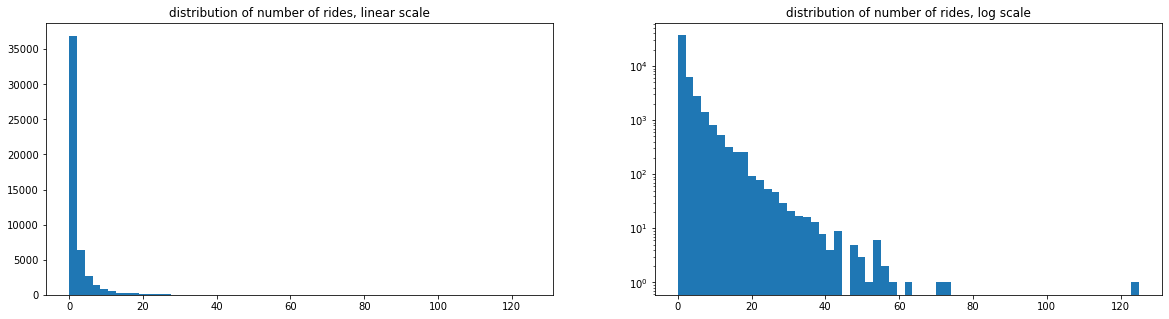

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(121)
bins = df['trips_in_first_30_days'].nunique()
plt.hist(df['trips_in_first_30_days'], bins=bins)
plt.title('distribution of number of rides, linear scale')

plt.subplot(122)
plt.hist(df['trips_in_first_30_days'], bins=bins)
plt.yscale('log')
plt.title('distribution of number of rides, log scale')
plt.show()

- A vast majority of riders took one ride in the preceding month. 
- One can visually tell that the number of users who took one ride is greater that the sum of the rest.

In [5]:
# examine the user who took the maximum rides
df[df['trips_in_first_30_days']==125]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8


# Feature Engineering

In [6]:
# change to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [7]:
# create a new column as the evaluation date for each user: excactly 6 months after their signup date.
df['eval_date'] = df.signup_date + DateOffset(months=6)

In [8]:
# Create a new column for classification of if the user is retained or not. It is based on if the user's last trip 
# falls within a month before evaluation date.
df['retained'] = (df.eval_date - DateOffset(days=30)) < df.last_trip_date

Percentage of retained users: 23.39%


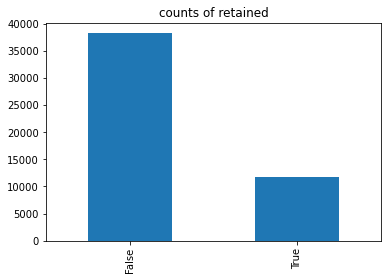

In [9]:
_ = df['retained'].sum() / len(df) * 100
print(f'Percentage of retained users: {round(_, 2)}%')
df['retained'].value_counts().plot(kind='bar', title='counts of retained')

- The number of retainted users is about 1/3 of those not retained.

In [10]:
# change to numeric
df.retained = df.retained.astype('int')

In [11]:
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,eval_date,retained
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,0


# Imputation

In [12]:
# check missing values by looking at Non-Null statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  eval_date               50000 non-null  dateti

- There are missing values in avg_rating_of_driver, phone, avg_rating_by_driver.

In [13]:
cols = ['avg_rating_of_driver', 'avg_rating_by_driver']
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean')
df[cols] = imp_mean.fit_transform(df[cols])

In [14]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [15]:
# the None are replaced in order for imputation
df.replace(to_replace=[None], value=np.nan, inplace=True)

imp_mf = SimpleImputer(strategy='most_frequent')
df[['phone']] = imp_mf.fit_transform(df[['phone']])

# Preprocessing

In [16]:
cols = ['city', 'phone', 'ultimate_black_user']
df[cols] = df[cols].astype('category')

In [17]:
df = pd.get_dummies(df)

In [18]:
X = df.drop(['signup_date', 'last_trip_date', 'eval_date', 'trips_in_first_30_days', 'retained'], axis=1)
y = df['retained']

In [19]:
X.head(3)

,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4.7,1.1,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,5.0,1.0,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,4.3,1.0,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0


In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [21]:
X_scaled

,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.174240,0.113506,0.328202,-0.397131,-0.372650,0.497684,-0.702890,1.983894,-0.935515,-0.655340,0.655340,-1.285285,1.285285
1,0.705241,-0.336268,-0.443394,-0.294653,0.431583,0.497684,1.422699,-0.504059,-0.935515,1.525926,-1.525926,0.778038,-0.778038
2,-0.533761,-0.336268,-0.443394,1.053741,-0.880771,0.497684,1.422699,-0.504059,-0.935515,-0.655340,0.655340,0.778038,-0.778038
3,-0.002760,0.293416,0.558679,0.514383,-0.602181,0.273342,-0.702890,1.983894,-0.935515,-0.655340,0.655340,-1.285285,1.285285
4,-0.356760,0.518303,0.147829,0.579106,-0.467266,0.273342,-0.702890,-0.504059,1.068930,1.525926,-1.525926,0.778038,-0.778038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.705241,-0.336268,-0.443394,1.053741,-0.029230,-1.297050,-0.702890,1.983894,-0.935515,-0.655340,0.655340,0.778038,-0.778038
49996,0.000000,-0.336268,-0.443394,-1.643048,-1.015686,-1.745733,1.422699,-0.504059,-0.935515,-0.655340,0.655340,0.778038,-0.778038
49997,0.705241,-0.336268,-0.443394,1.053741,-0.339360,0.497684,-0.702890,-0.504059,1.068930,1.525926,-1.525926,-1.285285,1.285285
49998,-2.834764,-0.336268,-0.443394,1.053741,-0.213205,-2.867442,1.422699,-0.504059,-0.935515,-0.655340,0.655340,0.778038,-0.778038


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# class weight is not considered
clf = LogisticRegression(penalty='l2', max_iter=300, random_state=42).fit(X, y)
print('The mean accuracy:', clf.score(X, y))
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

In [52]:
# f-beta score to 
scores = classification_report(y, y_pred, output_dict=True)
precision = scores['1']['precision']
recall = scores['1']['recall']

def f_score(beta=2):
    f_beta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    return f_beta

print(f'f2 score is: {np.round(f_score(2), 2)}')

f2 score is: 0.14


In [53]:
clf = LogisticRegression(max_iter=300, class_weight='balanced', random_state=42).fit(X, y)
print('The mean accuracy:', clf.score(X, y))
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

The mean accuracy: 0.63626
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     38306
           1       0.36      0.68      0.47     11694

    accuracy                           0.64     50000
   macro avg       0.61      0.65      0.60     50000
weighted avg       0.75      0.64      0.66     50000



- When class weight is considered, recall and f1-score improved retained user class

In [56]:
# f-beta score to 
scores = classification_report(y, y_pred, output_dict=True)
precision = scores['1']['precision']
recall = scores['1']['recall']

print(f'f2 score is: {np.round(f_score(2), 2)}')
print(f'f3 score is: {np.round(f_score(3), 2)}')
print(f'f4 score is: {np.round(f_score(4), 2)}')

f2 score is: 0.57
f3 score is: 0.62
f4 score is: 0.65


In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[23864, 14442],
       [ 3745,  7949]], dtype=int64)

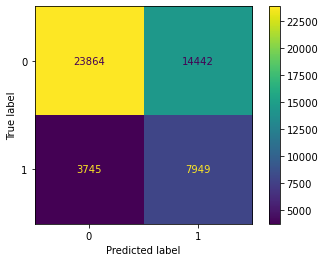

In [59]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X, y)
plt.show()

In [72]:
l1_ratio = 0.1
clf = LogisticRegression(penalty='elasticnet', l1_ratio=l1_ratio, max_iter=1000, class_weight='balanced', solver='saga', random_state=42).fit(X, y)
print('The mean accuracy:', clf.score(X, y))
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

The mean accuracy: 0.63618
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     38306
           1       0.35      0.68      0.47     11694

    accuracy                           0.64     50000
   macro avg       0.61      0.65      0.60     50000
weighted avg       0.75      0.64      0.66     50000



- The overall accuracy is 63%. It is hard to tell how the model bahaves with respect to each class
- This table clearly tells precision of non-retained user class 0 is great(86%). However for retained user class, the precision is very low (36%).
- Obviously, the model did a pour job for retained users class. This is of concern because we want to find ways to improve retain rate. Only a good model can help find the features that are important and the stakeholder can work on that.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.708


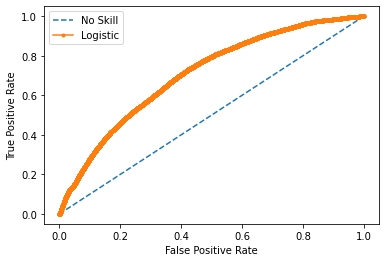

In [37]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

ns_probs = [0 for _ in range(len(y))]
# fit a model
model = LogisticRegression(max_iter=300, class_weight='balanced', random_state=42, solver='lbfgs')
model.fit(X, y)
# predict probabilities
lr_probs = model.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
- ROC curve indicates the model looks well.

Logistic: f1=0.466 auc=0.401


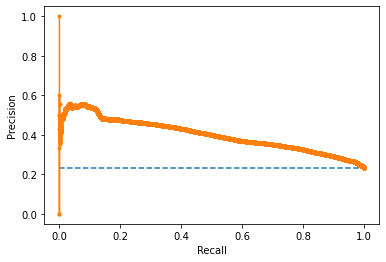

In [59]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

model = LogisticRegression(max_iter=300, class_weight='balanced', random_state=42, solver='lbfgs')
model.fit(X, y)

# predict probabilities
lr_probs = model.predict_proba(X)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
yhat = model.predict(X)
lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)
lr_f1, lr_auc = f1_score(y, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(lr_recall, lr_precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

- There is significant imbalance in the class. It is better to use PR curve, which shows the performance of the model is  modestly good. 

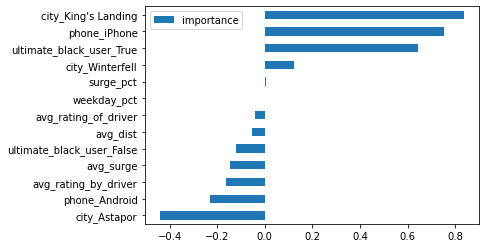

In [40]:
feature_importance = pd.DataFrame(data=clf.coef_.T, index=X.columns, columns = ['importance'])
feature_importance = feature_importance.sort_values('importance')
feature_importance.plot(kind='barh')

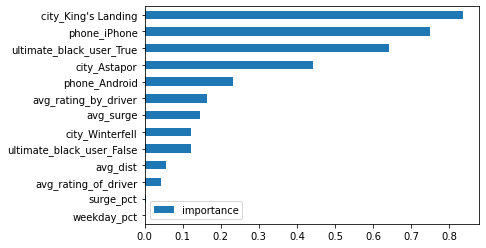

In [43]:
feature_importance = feature_importance.abs()
feature_importance = feature_importance.sort_values('importance')
feature_importance.plot(kind='barh')

In [66]:
# list importance values in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance

,importance
city_King's Landing,0.837407
phone_iPhone,0.750807
ultimate_black_user_True,0.642106
city_Astapor,0.441306
phone_Android,0.231654
avg_rating_by_driver,0.165229
avg_surge,0.146751
city_Winterfell,0.123052
ultimate_black_user_False,0.122954
avg_dist,0.055854


## Insight

- User's sign-up city of King's Landing is at least about 2 times higher in importance than other cities such as Astapor, Winterfell, etc.
- Feature importance of iPhone is 3 times higher than that of Android phone.
- Ultimate black user is about 5 times higher than that of not black user.
- Average rating by driver is 4 times higher than that of average rating of driver.
- Surge percent and weekday percent have minimal effect on retained user percentage.

- To help improve retaining rate, the company may want to consider the following measures:
    - find practical ways to retain more users in city of Astapor.
    - Encourage using iPhone in stead of Android phone.
    - Turn non balck users to black users.